### Central Limit Theorem

In this notebook, we take a closer look at the Central Limit Theorem and its role in A/B tests.

In simple terms, the Central Limit Theorem states that as you sample a random variable a large number of times, the distribution of the sample mean approaches a normal distribution, regardless of the initial distribution of the random variable.

How is this useful? Let's find out.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's consider a simple example.  Suppose our business has a website, and we want to optimize the time that users spend on the website.  To do this, the team has designed two variants of the website, and ran an experiment dividing users randomly into two groups.  Group A and Group B are each shown a different variant of the website, and the time they spent on the website is recorded.

To start, I use the log-normal distribution to generate time spent for users in each group.  I picked parameters such that Group A users spend a bit longer on the site than Group B users. I also combine the generated data into a pandas DataFrame (optional step, but it allows for easier graph making later).

I assume that Time on Site is measured in seconds.

In [11]:
# Generate data
np.random.seed(42)
mu_A, mu_B, scale = 3.6, 3.5, 0.75
time_A = np.random.lognormal(mean=mu_A, sigma=scale, size=500)
time_B = np.random.lognormal(mean=mu_B, sigma=scale, size=500)

# Combine into a dataframe
df = pd.DataFrame({
    'Time on Site': np.concatenate([time_A, time_B]),
    'Group': ['A'] * len(time_A) + ['B'] * len(time_B)
})

If we look at the group mean, Group A users spend a little more time on the website than Group B users.

In [12]:
# Calculate group means
group_means = df.groupby('Group')['Time on Site'].mean().to_dict()
for key, val in group_means.items():
    print(f"Group {key} mean: {val}")

Group A mean: 48.98272106717743
Group B mean: 44.42588255982537


Let's also plot out the histograms for the two groups. The distribution is right-skewed for both groups: most users stay on the site for a short amount of time, but a few are spending a long time on the site. 

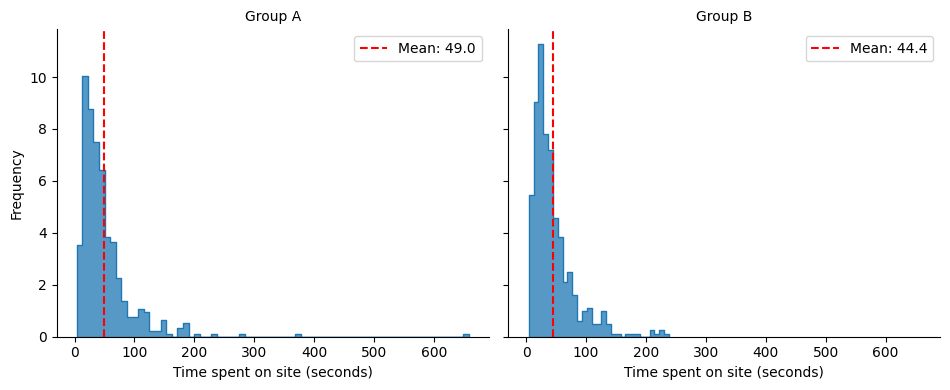

In [13]:
# Create FacetGrid
g = sns.FacetGrid(df, col='Group', height=4, aspect=1.2, sharey=True)
g.map_dataframe(sns.histplot, x='Time on Site', stat='frequency', element='step')

# Add vertical mean lines to each subplot
for ax, group in zip(g.axes.flat, group_means):
    mean_val = group_means[group]
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    ax.legend()

# Tweak labels
g.set_titles("Group {col_name}")
g.set_axis_labels("Time spent on site (seconds)", "Frequency")
plt.show()

How do we know whether the difference in the mean between the two groups is real, i.e. not due to chance? This is where the Central Limit Theorem becomes useful.

From the CLT, we know that the sample mean approaches a normal distribution when the sample size is large.  In other words, the sample mean for both Group A and Group B approach a normal distribution.  If we're interested in the difference of the sample mean between the two groups, we can think of that as a difference between two normal variables, which follows a normal distribution as well.

To verify this fact, I repeat the experiment 20 thousand times, each time recording the difference in the mean of group A and group B users.

In [14]:
# Experiment settings
n = 500              # users per group in each experiment
num_simulations = 20000

# Collect group differences
mean_diffs = []

for _ in range(num_simulations):
    time_A = np.random.lognormal(mean=mu_A, sigma=scale, size=n)
    time_B = np.random.lognormal(mean=mu_B, sigma=scale, size=n)
    diff = np.mean(time_A) - np.mean(time_B)
    mean_diffs.append(diff)

# Convert to array for stats
mean_diffs = np.array(mean_diffs)

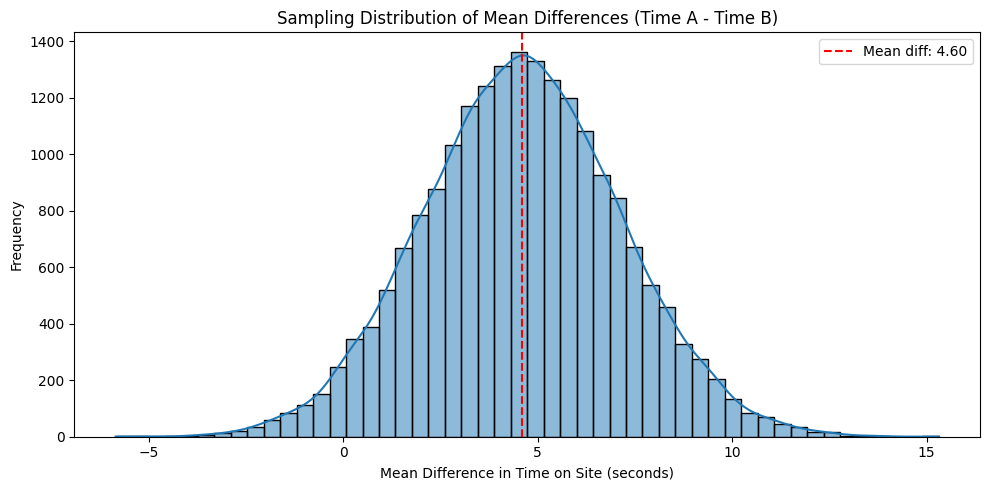

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(mean_diffs, bins=50, kde=True)
plt.axvline(mean_diffs.mean(), color='red', linestyle='--', label=f'Mean diff: {mean_diffs.mean():.2f}')
plt.title("Sampling Distribution of Mean Differences (Time A - Time B)")
plt.xlabel("Mean Difference in Time on Site (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

As our histogram above shows, the difference in the mean between Group A and Group B does follow a normal distribution.

This happens despite that Time on Site (our initial random variable) does not have a normal distribution; it has a log-normal distribution and is right-skewed.

In practice, we would have ran only one experiment and obtain one realization of the difference in mean.  Using the CLT, we can put confidence intervals around our estimate of the difference in mean.  This allows us to conclude whether this difference in mean is ``statistically significant," and whether in reality users in Group A spend more time on the website than users in Group B.